In [2]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
from gensim import corpora, models
from gensim.models import CoherenceModel, Phrases
from gensim.models.phrases import Phraser
from pprint import pprint

In [3]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [4]:
from dotenv import load_dotenv
import os

load_dotenv()
CSV_PATH =os.getenv("CSV_PATH")

df=pd.read_csv(CSV_PATH)
df.dropna(subset=["Message"], inplace=True)
df = df[df["Auteur"] != "Inconnu"]
df.drop_duplicates(inplace=True)
df.head(30)

,Auteur,Message,Emoji,Date
0,Gonçalo (G),Le sondage « Who's already using #🤖ydata-sdk ?...,😥,25 mars 2025 à 21:08
1,@Bunny,"Hi, I've gathered a sort of an automation then...",NaN,26 mars 2025 à 00:32
2,@Gonçalo (G),what are you trying to solve with that?,NaN,26 mars 2025 à 10:00
3,@ᵏᵒᵈᵈʸ ♱,what does this mean,NaN,26 mars 2025 à 10:01
6,Gonçalo (G),if you can pull the issues from ydata-profilin...,😛,26 mars 2025 à 15:27
7,Bunny,lol thats a really nice idea actually,😁,26 mars 2025 à 17:44
9,@Bunny,Anyway there is a chance I'll pull ydata-profi...,🙂,Modification : 26 mars 2025 à 17:45
10,@Gonçalo (G),would love to be in the loop for that,🙂,27 mars 2025 à 13:54
11,@Bunny,Can I share here or with you the results of th...,NaN,Modification : 27 mars 2025 à 13:57
12,@Gonçalo (G),sure! post it on ⁠📊ydata-profiling,😁,27 mars 2025 à 14:07


In [5]:
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException

def detect_lang(text):
    try:
        return detect(text)
    except LangDetectException:
        return "unknown"

# Ajouter une colonne 'lang'
df["lang"] = df["Message"].apply(detect_lang)

# Garder uniquement les messages détectés comme anglais
df = df[df["lang"] == "en"]

In [6]:
custom_stopwords = {
    'im', 'ive', 'ya', 'hi', 'hello', 'everyone', 'guy', 'guys', 'd', 'would', 'like', 'one',
    'get', 'also', 'know', 'dont', 'let', 'us', 'want', 'need', 'use', 'using', 'question',
    'help', 'thank', 'thanks', 'thing', 'things', 'hey', 'still', 'well', 'maybe', 'look',
    'looking','anyone', 'someone', 'please', 'make', 'good', 'work', 'time', 'really', 'trying', 'interested',
      'youre', 'take', 'find', 'something','he','great','un', 'ce', 'dans','new','chaneel','talk','le', 'tous',
    'st','fine','frind','d',
 }

def clean_text(text):
    text = str(text).strip()
    text = " ".join(text.split())
    text=text.lower()
    text = re.sub(r"http\S+", "", text)  
    text = re.sub(r"@\w+", "", text) 
    text = re.sub(r"#\w+", "", text)      
    text = re.sub(r'\d+', '', text) 
    text = re.sub(r"[^a-z\s]", "", text)
    stop_words = set(stopwords.words("english")).union(custom_stopwords)
    word_tokens = word_tokenize(text) 
    text = [word for word in word_tokens if word not in stop_words and len(word) > 1]
    if len(text) < 3:
        return ""
    lemmatizer = WordNetLemmatizer()
    text=[lemmatizer.lemmatize(word) for word in text]         
    return " ".join(text)

df["cleaned"] = df["Message"].apply(clean_text)
df = df[df["cleaned"] != ""] 
df["Autclean"] = df["Auteur"].str.replace("@", "", regex=False)
df.shape
df.head(30)


,Auteur,Message,Emoji,Date,lang,cleaned,Autclean
1,@Bunny,"Hi, I've gathered a sort of an automation then...",NaN,26 mars 2025 à 00:32,en,gathered sort automation pull github issue pub...,Bunny
6,Gonçalo (G),if you can pull the issues from ydata-profilin...,😛,26 mars 2025 à 15:27,en,pull issue ydataprofiling coding agent creatin...,Gonçalo (G)
7,Bunny,lol thats a really nice idea actually,😁,26 mars 2025 à 17:44,en,lol thats nice idea actually,Bunny
9,@Bunny,Anyway there is a chance I'll pull ydata-profi...,🙂,Modification : 26 mars 2025 à 17:45,en,anyway chance ill pull ydataprofiling issue an...,Bunny
11,@Bunny,Can I share here or with you the results of th...,NaN,Modification : 27 mars 2025 à 13:57,en,share result ai agent analyzation ydataprofili...,Bunny
12,@Gonçalo (G),sure! post it on ⁠📊ydata-profiling,😁,27 mars 2025 à 14:07,en,sure post ydataprofiling,Gonçalo (G)
14,W3ST,Coolest chatgpt convo dat export hacks? 3…2…1 ...,NaN,29 mars 2025 à 04:09,en,coolest chatgpt convo dat export hack go think...,W3ST
15,TheRock,Hello everyone. For any of the professional da...,NaN,29 mars 2025 à 21:18,en,professional data scientist currently nd year ...,TheRock
16,@TheRock,Hello everyone. For any of the professional da...,NaN,30 mars 2025 à 02:10,en,professional data scientist currently nd year ...,TheRock
17,VULCAN,"Hello, I have one question regarding the job m...",NaN,31 mars 2025 à 21:43,en,regarding job market section section based job...,VULCAN


In [7]:
print(df[['Message', 'cleaned']].head(10))

                                              Message  \
1   Hi, I've gathered a sort of an automation then...   
6   if you can pull the issues from ydata-profilin...   
7               lol thats a really nice idea actually   
9   Anyway there is a chance I'll pull ydata-profi...   
11  Can I share here or with you the results of th...   
12                 sure! post it on ⁠📊ydata-profiling   
14  Coolest chatgpt convo dat export hacks? 3…2…1 ...   
15  Hello everyone. For any of the professional da...   
16  Hello everyone. For any of the professional da...   
17  Hello, I have one question regarding the job m...   

                                              cleaned  
1   gathered sort automation pull github issue pub...  
6   pull issue ydataprofiling coding agent creatin...  
7                        lol thats nice idea actually  
9   anyway chance ill pull ydataprofiling issue an...  
11  share result ai agent analyzation ydataprofili...  
12                           sure po

Emoji le plus utilisé : 🙂
Emoji
🙂     53
👋     23
👍     23
😂     16
😅     12
😁     11
👀     10
😊     10
❤️    10
👆      9
Name: count, dtype: int64


C:\Users\hp\AppData\Local\Temp\ipykernel_8648\3627989743.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=user_counts.head(10).index, y=user_counts.head(10).values, palette="crest")


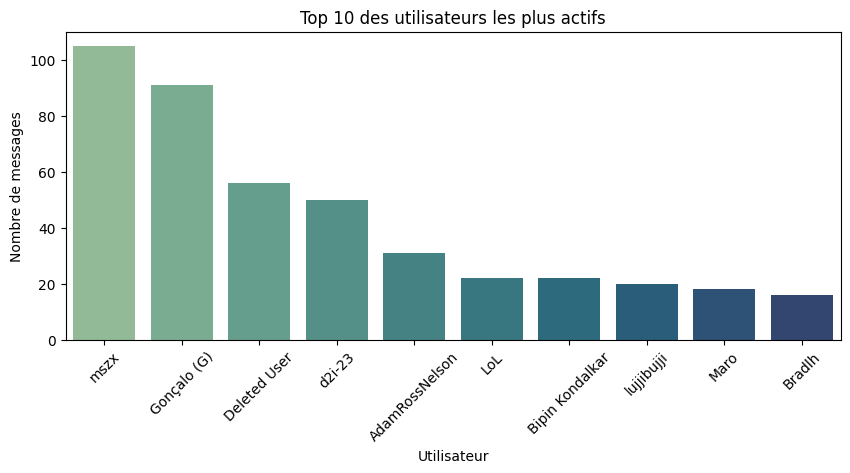

<Figure size 640x480 with 0 Axes>

In [8]:
# 🕵️‍♂️ 1. Emoji le plus fréquent
emoji_counts = df['Emoji'].value_counts()
Emoji_le_plus_utilisé = emoji_counts.idxmax()

print("Emoji le plus utilisé :", Emoji_le_plus_utilisé)
print(emoji_counts.head(10)) 


# 👤 2. Utilisateurs les plus actifs
user_counts = df['Autclean'].value_counts()
most_active_user = user_counts.idxmax()

plt.figure(figsize=(10, 4))
sns.barplot(x=user_counts.head(10).index, y=user_counts.head(10).values, palette="crest")
plt.title("Top 10 des utilisateurs les plus actifs")
plt.xlabel("Utilisateur")
plt.ylabel("Nombre de messages")
plt.xticks(rotation=45)
plt.show()
plt.savefig("Top 10 des utilisateurs les plus actifs")


C:\Users\hp\AppData\Local\Temp\ipykernel_8648\2437636684.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=frequence_par_heure.index, y=frequence_par_heure.values, palette="viridis")


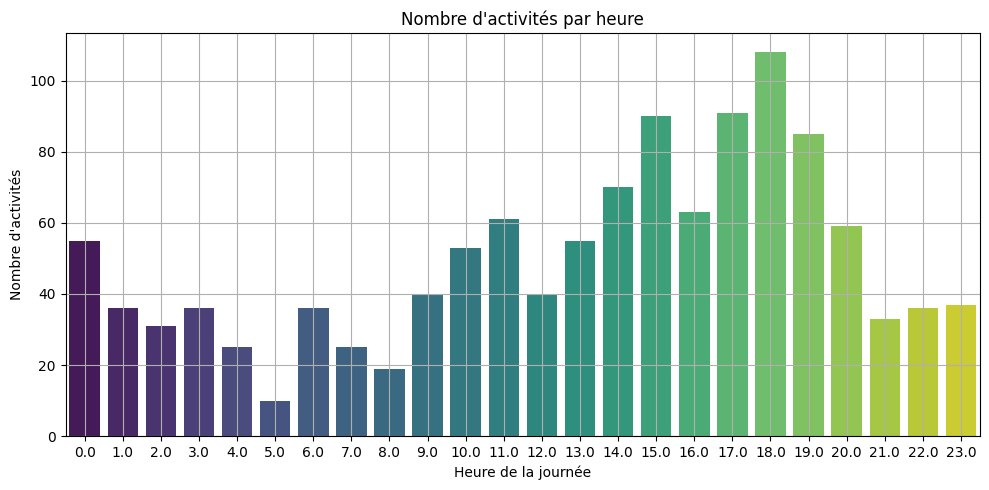

In [9]:
import locale
locale.setlocale(locale.LC_TIME, 'French_France')

df["Date_clean"] = df["Date"].str.replace("à", "", regex=False).str.strip()

# Conversion en datetime
df["Date_clean"] = pd.to_datetime(df["Date_clean"], format="%d %B %Y %H:%M", errors="coerce")

df["heure"] = df["Date_clean"].dt.hour
frequence_par_heure = df["heure"].value_counts().sort_index()

# Tracer
plt.figure(figsize=(10,5))
sns.barplot(x=frequence_par_heure.index, y=frequence_par_heure.values, palette="viridis")
plt.title("Nombre d'activités par heure")
plt.xlabel("Heure de la journée")
plt.ylabel("Nombre d'activités")
plt.xticks(range(24))
plt.grid(True)
plt.tight_layout()
plt.savefig("frequence_par_heure.png")
plt.show()


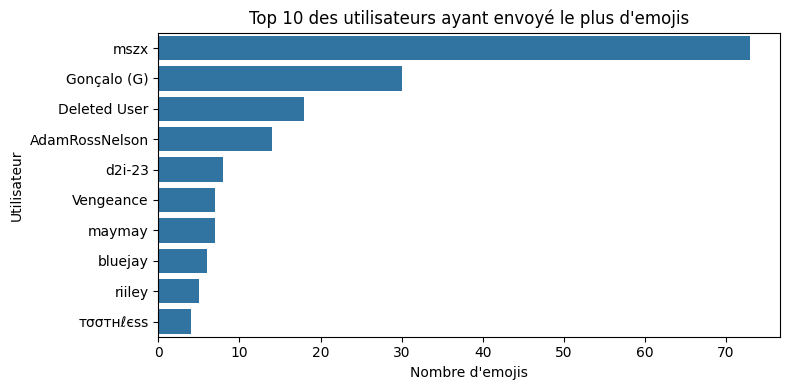

In [10]:
# 5. Usage d'emojis par utilisateur (top 10)
emoji_counts_by_user = (
    df[df['Emoji'].astype(bool)]
      .groupby('Autclean')['Emoji']
      .count()
      .sort_values(ascending=False)
      .head(10)
)
plt.figure(figsize=(8,4))
sns.barplot(x=emoji_counts_by_user.values, y=emoji_counts_by_user.index)
plt.title("Top 10 des utilisateurs ayant envoyé le plus d'emojis")
plt.xlabel("Nombre d'emojis")
plt.ylabel("Utilisateur")
plt.tight_layout()
plt.savefig("emoji_par_utilisateur.png", dpi=300, bbox_inches='tight')
plt.show()

[('data', 527), ('ai', 264), ('project', 174), ('model', 114), ('learning', 108), ('science', 93), ('people', 80), ('working', 66), ('python', 61), ('machine', 61), ('dataset', 58), ('image', 56), ('job', 54), ('research', 54), ('course', 52), ('way', 51), ('think', 50), ('question', 49), ('ml', 48), ('could', 48), ('best', 47), ('issue', 45), ('idea', 45), ('field', 45), ('modifi', 45), ('experience', 45), ('company', 45), ('tool', 45), ('learn', 44), ('problem', 44)]


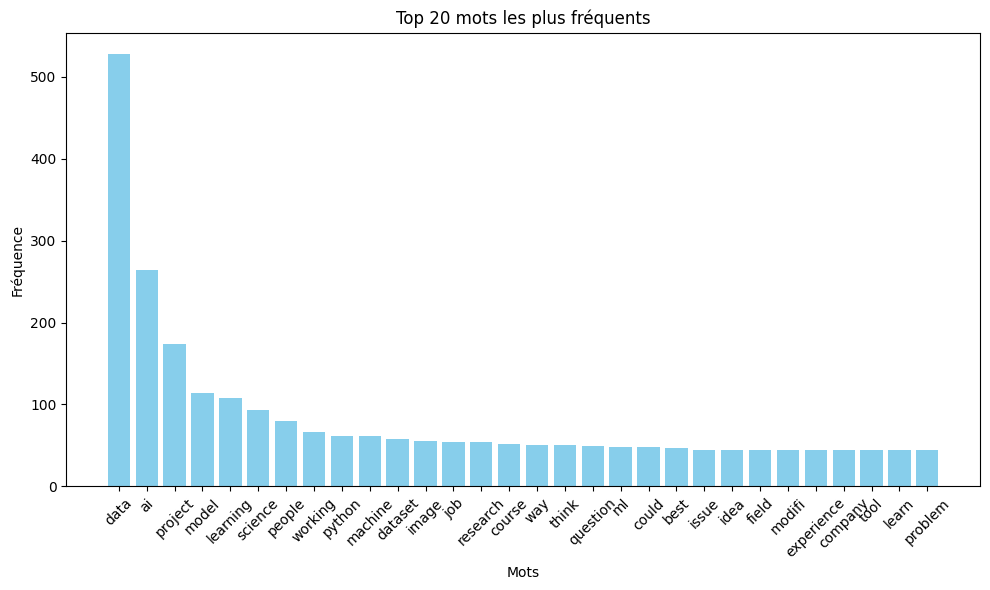

<Figure size 640x480 with 0 Axes>

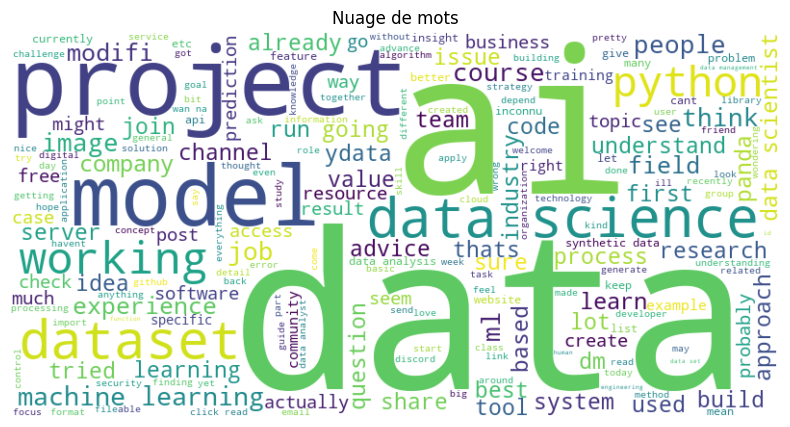

<Figure size 640x480 with 0 Axes>

In [11]:
from collections import Counter
from wordcloud import WordCloud

all_words = []
for text in df["cleaned"]: 
    all_words.extend(text.split())

freq = Counter(all_words)

common_words = freq.most_common(30)
print(common_words)

# 4. Visualisation : barplot
plt.figure(figsize=(10, 6))
plt.bar([word for word, count in common_words], [count for word, count in common_words], color='skyblue')
plt.xticks(rotation=45)
plt.title("Top 20 mots les plus fréquents")
plt.xlabel("Mots")
plt.ylabel("Fréquence")
plt.tight_layout()
plt.show()
plt.savefig("Top 20 mots les plus fréquents")

#nuage des mots
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(all_words))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Nuage de mots")
plt.show()
plt.savefig("Nuage de mots")


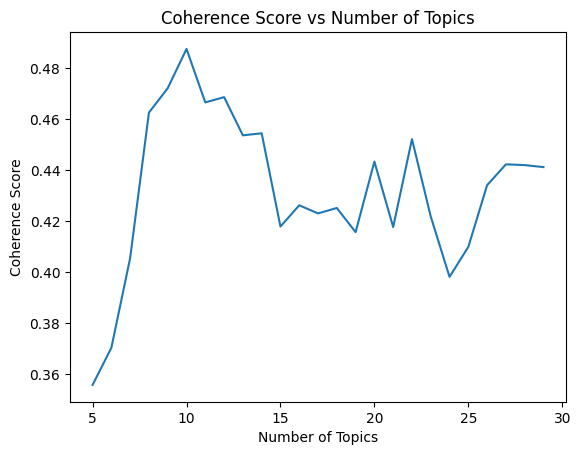

 Meilleur nombre de topics : 10 avec coherence = 0.4875
[(0,
  '0.250*"project" + 0.052*"ml" + 0.045*"going" + 0.038*"team" + 0.030*"repo" '
  '+ 0.029*"report" + 0.028*"give" + 0.024*"probably" + 0.023*"yet" + '
  '0.023*"free"'),
 (1,
  '0.055*"could" + 0.045*"learning" + 0.041*"research" + 0.038*"tell" + '
  '0.031*"created" + 0.031*"information" + 0.031*"id" + 0.026*"metric" + '
  '0.025*"technique" + 0.024*"recently"'),
 (2,
  '0.050*"python" + 0.049*"best" + 0.039*"machine_learning" + 0.037*"check" + '
  '0.036*"week" + 0.033*"library" + 0.030*"pipeline" + 0.026*"first" + '
  '0.024*"dm" + 0.023*"look"'),
 (3,
  '0.104*"channel" + 0.070*"inconnu" + 0.053*"anything" + 0.045*"server" + '
  '0.031*"seems" + 0.024*"import" + 0.024*"grateful" + 0.023*"two" + '
  '0.022*"ill" + 0.022*"exam"'),
 (4,
  '0.286*"data" + 0.041*"science" + 0.029*"nist" + 0.025*"scientist" + '
  '0.024*"analysis" + 0.024*"currently" + 0.020*"field" + 0.020*"ydata" + '
  '0.016*"various" + 0.016*"analyst"'),
 

<Figure size 640x480 with 0 Axes>

In [12]:
texts = [text.split() for text in df["cleaned"]]

# Création de bigrammes
bigram = Phrases(texts, min_count=5, threshold=30)
bigram_mod = Phraser(bigram)
texts_bigram = [bigram_mod[doc] for doc in texts]

# Dictionnaire et corpus
id2word = corpora.Dictionary(texts_bigram)
id2word.filter_extremes(no_below=5, no_above=0.6)
corpus = [id2word.doc2bow(text) for text in texts_bigram]

# Fonction pour calculer la cohérence
def compute_coherence_values(dictionary, corpus, texts, start, limit, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step): 
        model = models.LdaModel(corpus=corpus,
                                id2word=dictionary,
                                num_topics=num_topics,
                                random_state=100,
                                update_every=1,
                                chunksize=100,
                                passes=10,
                                alpha='auto',
                                per_word_topics=False)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

# Tester plusieurs nombres de topics
start, limit, step = 5, 30, 1
model_list, coherence_values = compute_coherence_values(id2word, corpus, texts_bigram, start, limit, step)

# Figure de score de cohérence
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Score vs Number of Topics")
plt.show()
plt.savefig("Coherence Score vs Number of Topics")

# Meilleur modèle
best_index = coherence_values.index(max(coherence_values))
best_model = model_list[best_index]
best_num_topics = start + best_index * step
print(f" Meilleur nombre de topics : {best_num_topics} avec coherence = {coherence_values[best_index]:.4f}")
pprint(best_model.print_topics())


# Assigner les topics au DataFrame
df["topic"] = [max(best_model[doc], key=lambda x: x[1])[0] for doc in corpus]

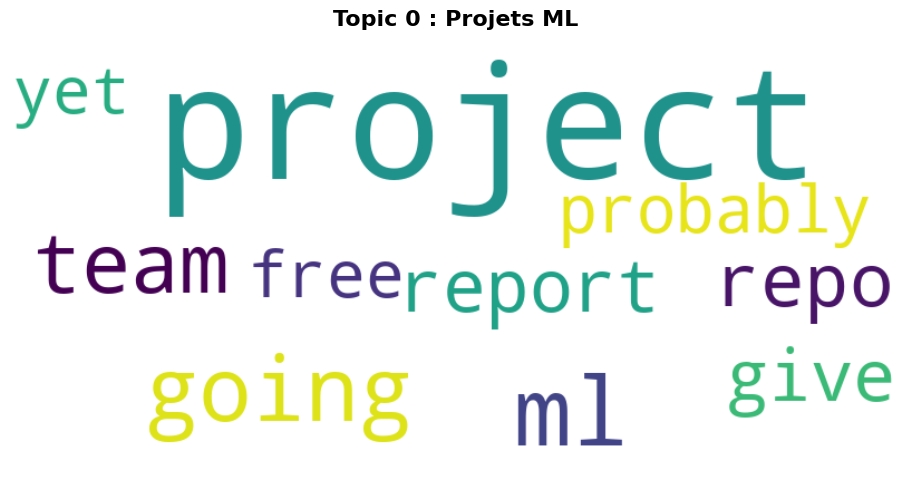

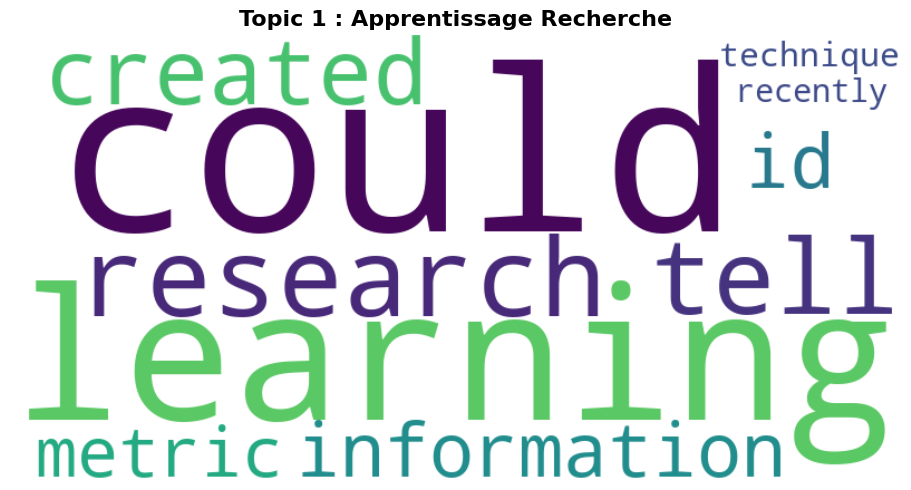

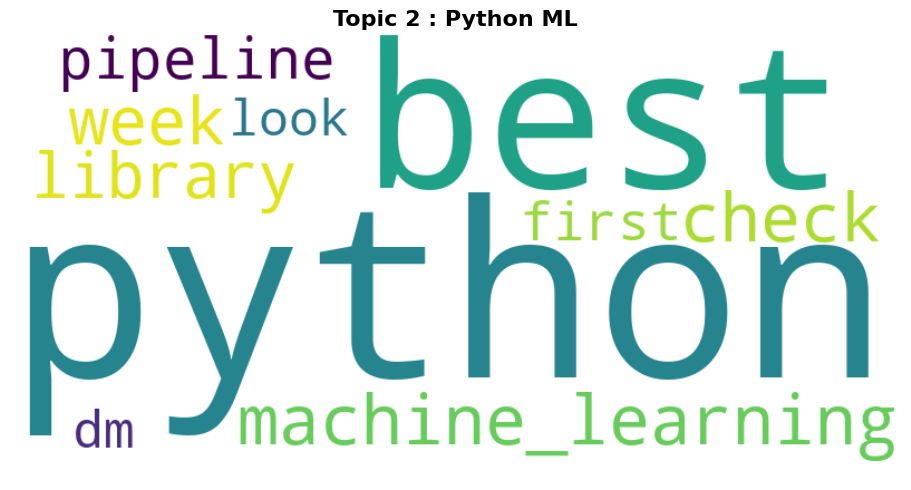

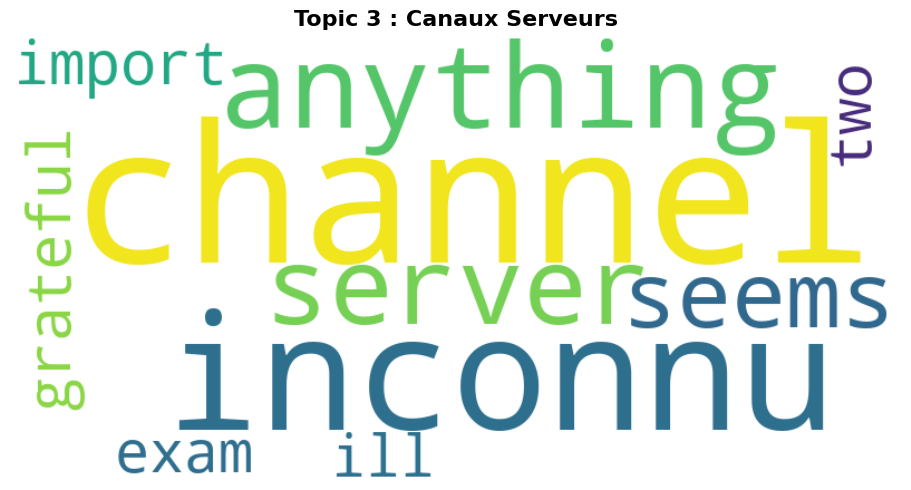

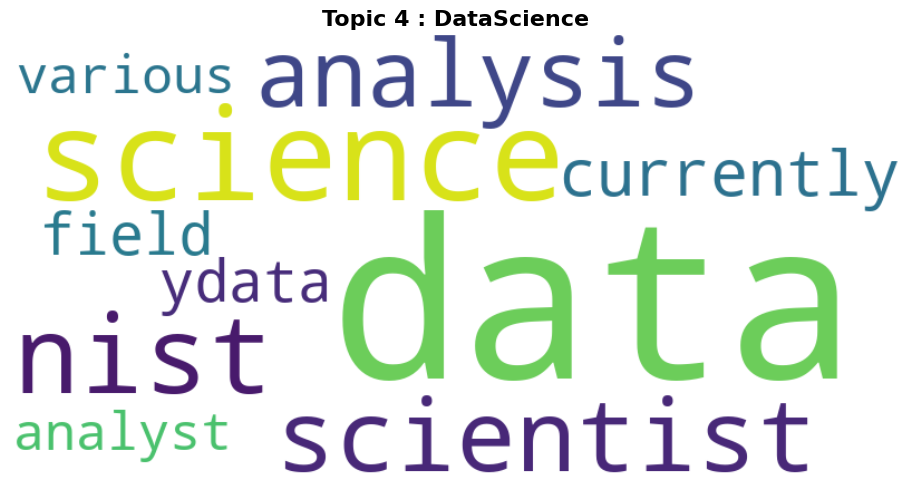

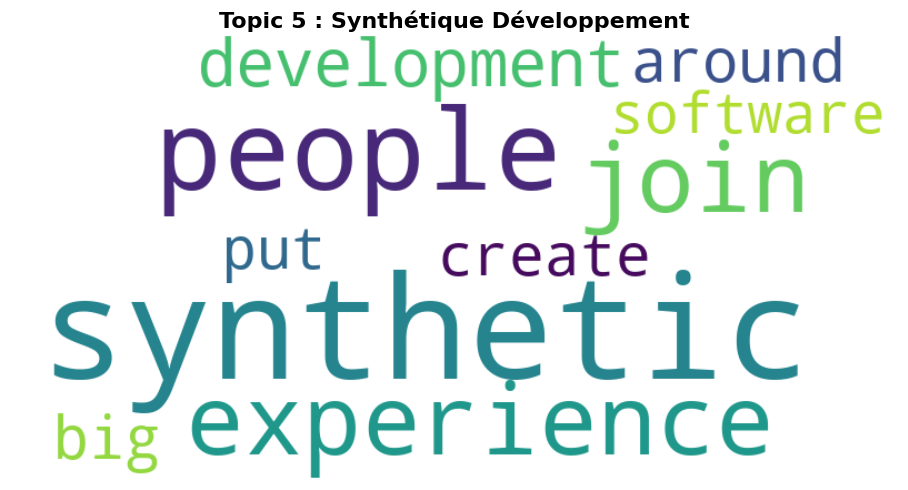

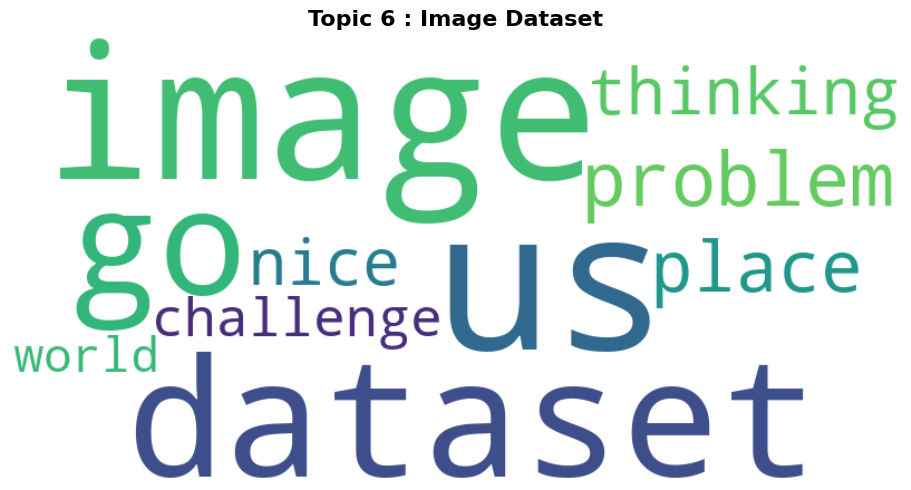

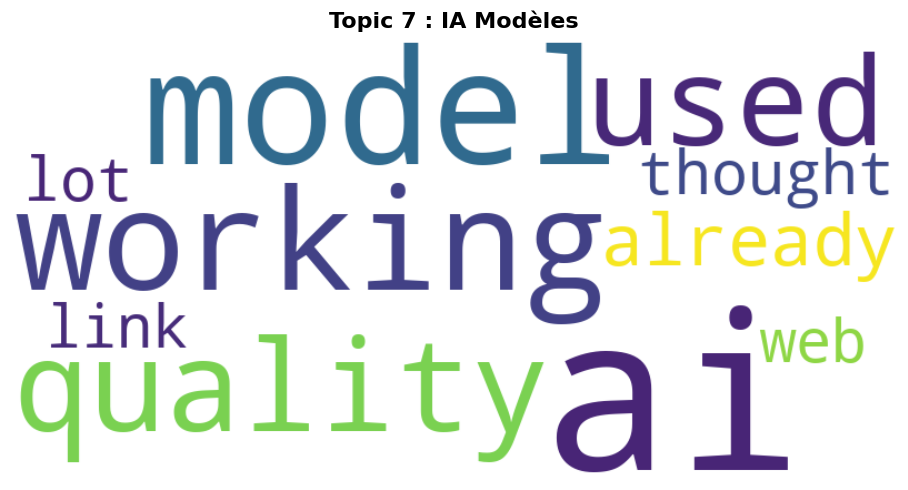

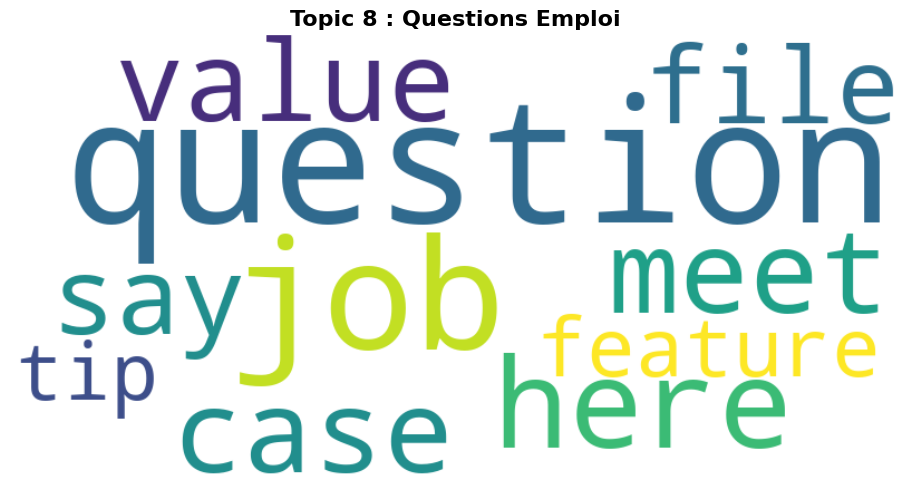

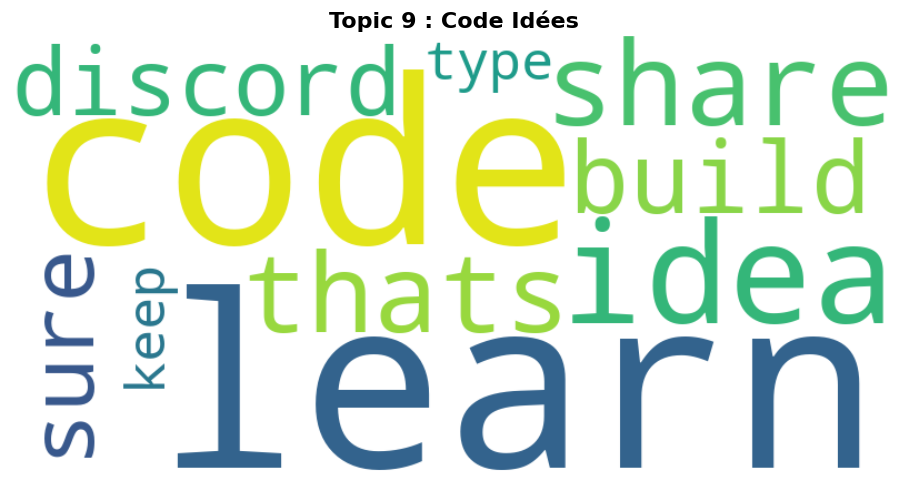

In [20]:
topics = {
    0: '0.250*"project" + 0.052*"ml" + 0.045*"going" + 0.038*"team" + 0.030*"repo" + 0.029*"report" + 0.028*"give" + 0.024*"probably" + 0.023*"yet" + 0.023*"free"',
    1: '0.055*"could" + 0.045*"learning" + 0.041*"research" + 0.038*"tell" + 0.031*"created" + 0.031*"information" + 0.031*"id" + 0.026*"metric" + 0.025*"technique" + 0.024*"recently"',
    2: '0.050*"python" + 0.049*"best" + 0.039*"machine_learning" + 0.037*"check" + 0.036*"week" + 0.033*"library" + 0.030*"pipeline" + 0.026*"first" + 0.024*"dm" + 0.023*"look"',
    3: '0.104*"channel" + 0.070*"inconnu" + 0.053*"anything" + 0.045*"server" + 0.031*"seems" + 0.024*"import" + 0.024*"grateful" + 0.023*"two" + 0.022*"ill" + 0.022*"exam"',
    4: '0.286*"data" + 0.041*"science" + 0.029*"nist" + 0.025*"scientist" + 0.024*"analysis" + 0.024*"currently" + 0.020*"field" + 0.020*"ydata" + 0.016*"various" + 0.016*"analyst"',
    5: '0.065*"synthetic" + 0.037*"people" + 0.029*"experience" + 0.028*"join" + 0.026*"development" + 0.022*"around" + 0.022*"big" + 0.021*"create" + 0.020*"put" + 0.019*"software"',
    6: '0.078*"us" + 0.071*"image" + 0.058*"dataset" + 0.046*"go" + 0.038*"problem" + 0.034*"place" + 0.030*"thinking" + 0.029*"nice" + 0.025*"challenge" + 0.020*"world"',
    7: '0.094*"ai" + 0.044*"model" + 0.034*"working" + 0.028*"quality" + 0.026*"used" + 0.020*"already" + 0.019*"thought" + 0.019*"lot" + 0.018*"link" + 0.018*"web"',
    8: '0.065*"question" + 0.051*"job" + 0.032*"here" + 0.028*"meet" + 0.028*"case" + 0.026*"value" + 0.024*"say" + 0.024*"file" + 0.023*"feature" + 0.022*"tip"',
    9: '0.045*"learn" + 0.041*"code" + 0.040*"idea" + 0.031*"share" + 0.031*"thats" + 0.026*"build" + 0.026*"discord" + 0.024*"sure" + 0.023*"type" + 0.023*"keep"',
}

topic_domains = {
    0: "Projets_ML",
    1: "Apprentissage_Recherche",
    2: "Python_ML",
    3: "Canaux_Serveurs",
    4: "DataScience",
    5: "Synthétique_Développement",
    6: "Image_Dataset",
    7: "IA_Modèles",
    8: "Questions_Emploi",
    9: "Code_Idées",
}

# Fonction de parsing
def parse_topic_string(topic_str):
    pairs = topic_str.split(' + ')
    return {p.split('*')[1].strip('"'): float(p.split('*')[0]) for p in pairs}


for i, domain in topic_domains.items():
    word_freq = parse_topic_string(topics[i])
    wc = WordCloud(background_color='white', width=800, height=400)
    wc.generate_from_frequencies(word_freq)

    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f"Topic {i} : {domain.replace('_', ' ')}", fontsize=16, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    

In [13]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

pyldavis_prepared = gensimvis.prepare(best_model, corpus, id2word)
pyLDAvis.display(pyldavis_prepared)

In [14]:
#sentiments
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
vaders = pd.DataFrame([sia.polarity_scores(text) for text in df['Message']])
df_with_sentiment = pd.concat([df.reset_index(drop=True), vaders], axis=1)
df_with_sentiment.head()

,Auteur,Message,Emoji,Date,lang,cleaned,Autclean,Date_clean,heure,topic,neg,neu,pos,compound
0,@Bunny,"Hi, I've gathered a sort of an automation then...",NaN,26 mars 2025 à 00:32,en,gathered sort automation pull github issue pub...,Bunny,2025-03-26 00:32:00,0.0,4,0.0,0.942,0.058,0.4019
1,Gonçalo (G),if you can pull the issues from ydata-profilin...,😛,26 mars 2025 à 15:27,en,pull issue ydataprofiling coding agent creatin...,Gonçalo (G),2025-03-26 15:27:00,15.0,4,0.0,0.712,0.288,0.7964
2,Bunny,lol thats a really nice idea actually,😁,26 mars 2025 à 17:44,en,lol thats nice idea actually,Bunny,2025-03-26 17:44:00,17.0,9,0.0,0.404,0.596,0.7089
3,@Bunny,Anyway there is a chance I'll pull ydata-profi...,🙂,Modification : 26 mars 2025 à 17:45,en,anyway chance ill pull ydataprofiling issue an...,Bunny,NaT,NaN,3,0.0,0.900,0.100,0.2500
4,@Bunny,Can I share here or with you the results of th...,NaN,Modification : 27 mars 2025 à 13:57,en,share result ai agent analyzation ydataprofili...,Bunny,NaT,NaN,4,0.0,0.879,0.121,0.2960


C:\Users\hp\AppData\Local\Temp\ipykernel_8648\2150931951.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="topic", y="compound", data=df_with_sentiment, palette="viridis")


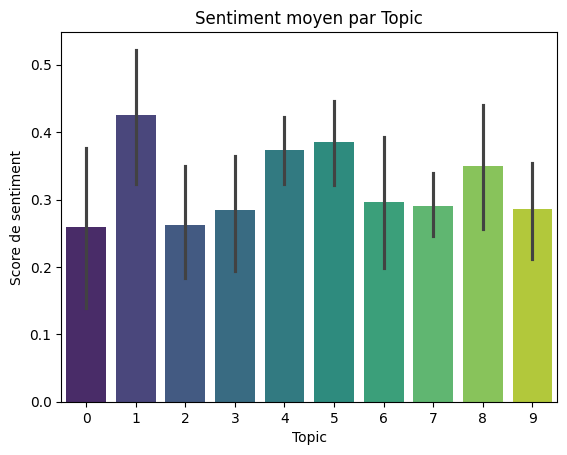

C:\Users\hp\AppData\Local\Temp\ipykernel_8648\2150931951.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="topic", y="compound", data=df_with_sentiment, palette="viridis")


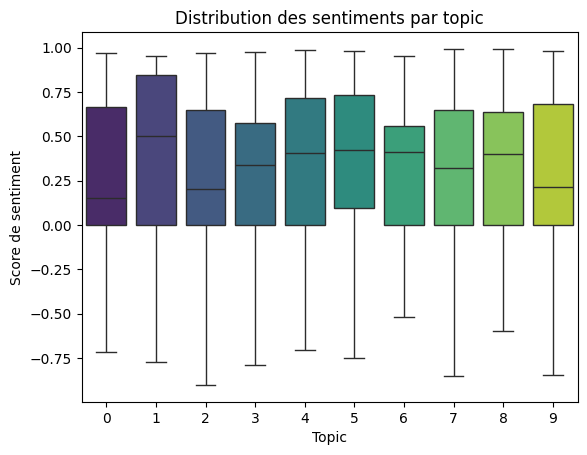

<Figure size 640x480 with 0 Axes>

In [15]:
sns.barplot(x="topic", y="compound", data=df_with_sentiment, palette="viridis")
plt.title("Sentiment moyen par Topic")
plt.xlabel("Topic")
plt.ylabel("Score de sentiment")
plt.show()
plt.savefig("Sentiment moyen par Topic")

sns.boxplot(x="topic", y="compound", data=df_with_sentiment, palette="viridis")
plt.title("Distribution des sentiments par topic")
plt.xlabel("Topic")
plt.ylabel("Score de sentiment")
plt.show()
plt.savefig("Distribution des sentiments par topic")